In [1]:
import pandas as pd
from ollama import chat
from ollama import ChatResponse
from tqdm import tqdm

In [2]:
X = pd.read_csv('2X_test_finetuning.csv')
y = pd.read_csv('2y_test_finetuning.csv')

In [3]:
df = pd.concat([X, y], axis = 1)

In [4]:
df

,Neutralized SMILES,ATC Codes
0,Cc1ncc(COC(=O)CCC(=O)OCCN(C)C)c(CO)c1O,N06BX
1,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3...,G04BD
2,C/C(O)=N\\c1ccc(O)cc1,N02BE
3,CC1(C(=O)O)CCC2(C)CCC3(C)C(=CC(=O)C4C5(C)CCC(O...,R02AA
4,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,P02CA
...,...,...
713,C[C@@](O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#...,L02BB
714,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)nc21,J01MA
715,CC(=O)N[C@@H](CC(=O)N[C@@H](CCC(=O)O)C(=O)O)C(...,R01AC; S01GX
716,C[C@@H]1C[C@@H](OC(=O)c2cccnc2)CC(C)(C)C1,C04AC


In [ ]:
s_smiles = X['Neutralized SMILES'][1]
print(s_smiles)
response: ChatResponse = chat(model='atc4-predictor3', messages=[
    {"role": "user", "content": s_smiles}
])
print(response['message']['content'])

In [ ]:
if "predicted_atc4" not in df.columns:
    df["predicted_atc4"] = None
import asyncio
from ollama import AsyncClient

async def chat(message):
    response = await AsyncClient().chat(model='atc4-predictor3', messages=message)
    return response['message']['content']

for i in range(len(df)):
    smiles = df.at[i, "Neutralized SMILES"]
    s_smiles = smiles.replace("\\", "\\\\")
    message=[
        {"role": "user", "content": s_smiles}
    ]
    try:
      pred = await chat(message)
    except ollama.ResponseError as e:
      print('Error:', e.error)
      if e.status_code == 404:
        ollama.pull(model)
    df.at[i, "predicted_atc4"] = pred

    if i % 10 == 0:
        df.to_csv("predicted_atc4_partial.csv", index=False)
        print("Guardado parcial")

df.to_csv("predicted_atc4_datasetfinetuning.csv", index=False)

In [7]:
preds = pd.read_csv('../predicted_atc4_datasetfinetuning.csv')
preds = preds['predicted_atc4']

In [8]:
preds

0       A07BA07
1       A01AA02
2       A07AA07
3      J/08/036
4       A07AA07
         ...   
713     J Edg\n
714     A07BA08
715     A07AA07
716       J\n\n
717       J/N03
Name: predicted_atc4, Length: 718, dtype: object

In [9]:
# Convert a string that simulates a list to a real list
def convert_string_list(element):
    # Delete [] of the string
    element = element[0:len(element)]
    # Create a list that contains each code as e.g. 'A'
    ATC_list = list(element.split('; '))
    for index, code in enumerate(ATC_list):
        # Delete '' of the code
        ATC_list[index] = code[0:len(code)]
    return ATC_list

In [11]:
clear_preds = []
for i, pred in enumerate(preds):
    level4_pred = pred[0:5]
    if len(level4_pred) == 5:
        if level4_pred[0].isalpha():
            if level4_pred[1:3].isnumeric():
                if level4_pred[3].isalpha():
                    if level4_pred[4].isalpha():
                        clear_preds.append(level4_pred)
                    else:
                        clear_preds.append("Invalid prediction")
                else:
                    clear_preds.append("Invalid prediction")
            else:
                clear_preds.append("Invalid prediction")    
        else:
            clear_preds.append("Invalid prediction")
    else:
        clear_preds.append("Invalid prediction")
clear_preds

['A07BA',
 'A01AA',
 'A07AA',
 'Invalid prediction',
 'A07AA',
 'U03AA',
 'A07AA',
 'A07AA',
 'Invalid prediction',
 'M01AA',
 'E15AA',
 'Invalid prediction',
 'A07BA',
 'J17AA',
 'J01AA',
 'A07BC',
 'Invalid prediction',
 'Invalid prediction',
 'J01AA',
 'Invalid prediction',
 'A07BA',
 'M01AA',
 'A07BA',
 'A07BA',
 'A07AA',
 'J01AA',
 'A02AA',
 'A01AA',
 'A07BA',
 'J01AA',
 'A07BC',
 'A07AA',
 'M01AA',
 'A07AA',
 'A07BA',
 'A07BA',
 'J05AE',
 'E17AA',
 'A02AA',
 'M01AA',
 'A02AA',
 'A35BD',
 'A02AA',
 'T01AA',
 'A01AA',
 'A02AD',
 'A07BA',
 'M01AA',
 'A07BA',
 'A07BA',
 'A07AA',
 'N05BD',
 'M01AA',
 'Invalid prediction',
 'A07BA',
 'A07BC',
 'M01AA',
 'A01AA',
 'A01AA',
 'J01AA',
 'A07AA',
 'Invalid prediction',
 'A01EA',
 'M01AA',
 'J01AA',
 'A07BA',
 'A07AA',
 'J15AA',
 'Invalid prediction',
 'J15AA',
 'A01AA',
 'A02AA',
 'J04AA',
 'A07AA',
 'J05BA',
 'J05BA',
 'Invalid prediction',
 'A07AA',
 'J05AA',
 'A02AA',
 'A02AA',
 'A07BA',
 'Invalid prediction',
 'M01AA',
 'J01AA',
 'J05BA

In [12]:
print(clear_preds.count("Invalid prediction"))
print(len(clear_preds)-clear_preds.count("Invalid prediction"))

109
609


In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict
# Create a dictionary of integers
counter = defaultdict(int)

for pred in clear_preds:
    # ATC_level1_list = convert_string_list(row['ATC_level1'])
    if pred != "Invalid prediction":
        counter[pred] += 1
counter

defaultdict(int,
            {'A07BA': 98,
             'A01AA': 43,
             'A07AA': 140,
             'U03AA': 2,
             'M01AA': 59,
             'E15AA': 1,
             'J17AA': 2,
             'J01AA': 61,
             'A07BC': 31,
             'A02AA': 23,
             'J05AE': 1,
             'E17AA': 5,
             'A35BD': 1,
             'T01AA': 1,
             'A02AD': 1,
             'N05BD': 2,
             'A01EA': 12,
             'J15AA': 14,
             'J04AA': 3,
             'J05BA': 22,
             'J05AA': 14,
             'M01AB': 2,
             'M05AA': 18,
             'N06AC': 1,
             'H01AA': 2,
             'D06AA': 8,
             'A07EA': 2,
             'A08AA': 3,
             'N06AA': 1,
             'J16AQ': 1,
             'M05AB': 5,
             'D06AX': 1,
             'D03EA': 1,
             'A09AA': 8,
             'M02AA': 1,
             'J16AA': 5,
             'A06AA': 1,
             'T19AA': 1,
             'T81AA'

In [14]:
len(counter)

49

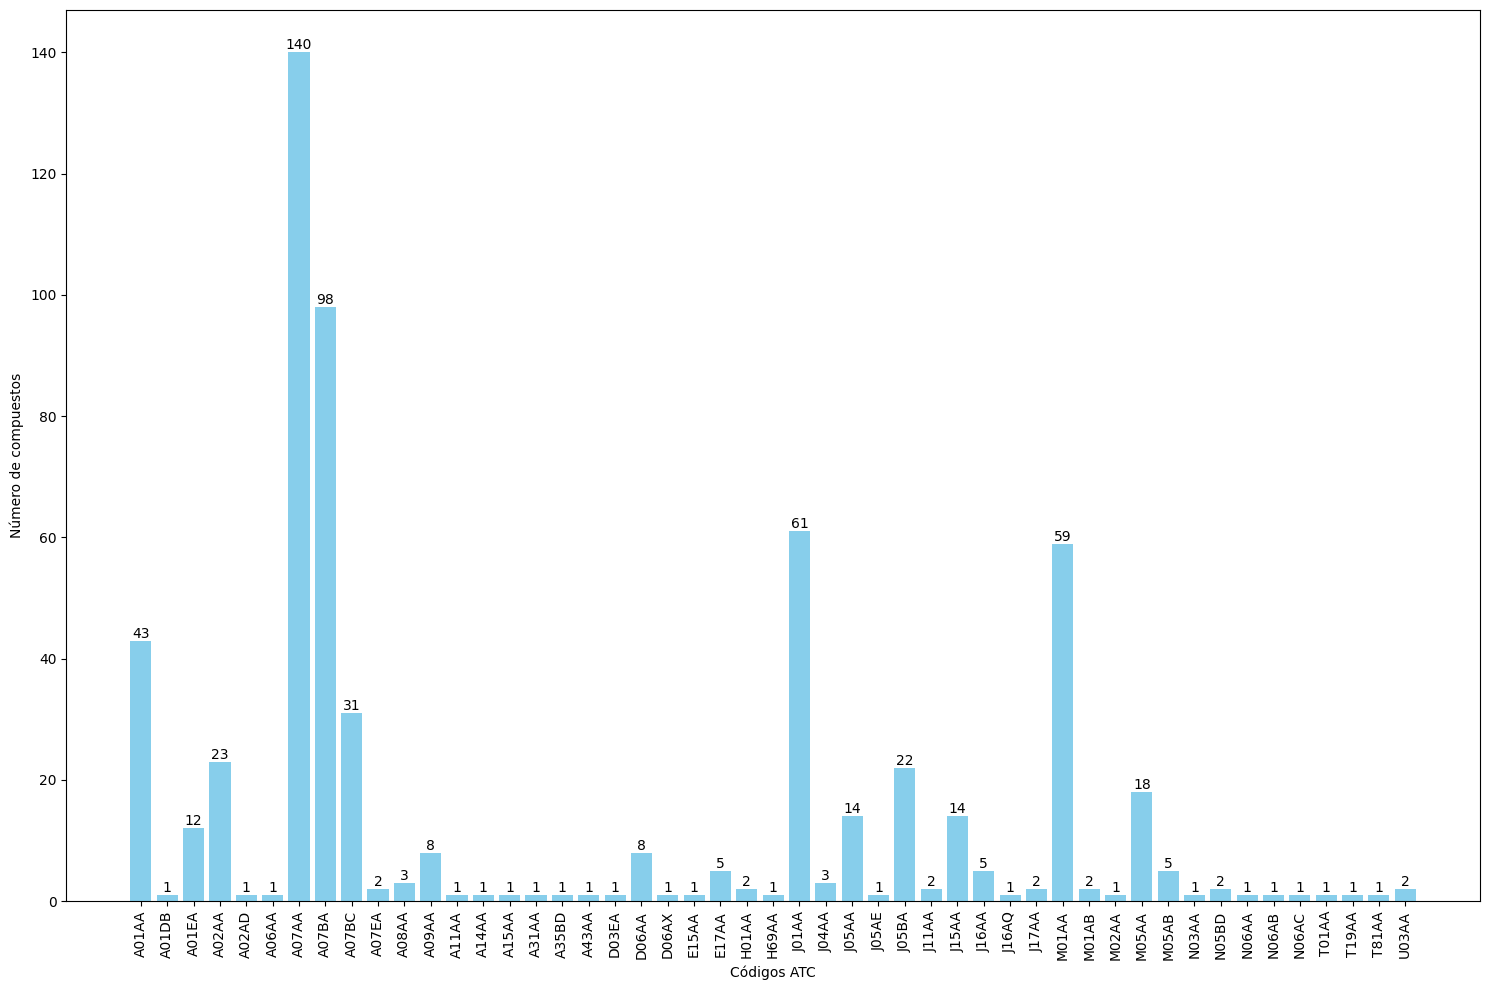

In [15]:
dict_level1 = dict(sorted(counter.items()))

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

for code, num in dict_level1.items():
    p = ax.bar(code, num, color='skyblue')
    ax.bar_label(p)
    
plt.xlabel('Códigos ATC')
plt.ylabel('Número de compuestos')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig('1stlevel.png', bbox_inches='tight')

In [12]:
df_test = y
df_test['ATC Codes']
# valid_indices = [i for i, pred in enumerate(clear_preds) if pred != "Invalid prediction"]

# clear_preds = [clear_preds[i] for i in valid_indices]
# df_test = df_test.iloc[valid_indices].reset_index(drop=True)

0             N06BX
1             G04BD
2             N02BE
3             R02AA
4             P02CA
           ...     
713           L02BB
714           J01MA
715    R01AC; S01GX
716           C04AC
717           R06AB
Name: ATC Codes, Length: 718, dtype: object

In [13]:
df_test

,ATC Codes
0,N06BX
1,G04BD
2,N02BE
3,R02AA
4,P02CA
...,...
713,L02BB
714,J01MA
715,R01AC; S01GX
716,C04AC


In [14]:
# for i, pred in enumerate(clear_preds):
#     if pred == "Invalid prediction":
#         print(pred)

In [15]:
len(clear_preds)

718

In [16]:
def precision(output_beam2, df_test):
    total_compounds = len(df_test)
    # Initialize counters for total matches and valid comparisons at each level
    total_matches = [0, 0, 0, 0]
    valid_comparisons = [total_compounds] * 4 # Start with all compounds being valid for comparison at every level

    # Iterate through the predictions for each compound
    for i, list_preds in enumerate(output_beam2):
        true_codes = df_test['ATC Codes'].iloc[i]
        true_codes = convert_string_list(true_codes)
        num_preds = [len(list_preds)]*4
        level_matches = [0, 0, 0, 0]
        not_compared = [False, True, True, True]
        # Compare predicted codes with true codes
        match_found = [False, False, False, False]
        p = list_preds
        for true_code in true_codes:
            # Compare each level
            if len(p) == 5:
                if p[0] == true_code[0]:
                    match_found[0] = True
                    if p[1:3] == true_code[1:3]:
                        match_found[1] = True
                        if p[3] == true_code[3]:
                            match_found[2] = True
                            if p[4] == true_code[4]:
                                match_found[3] = True
            for level in range(4):
                if match_found[level]:
                    # If at least one time it can compare with level y+1 so it converts to False
                    # Level y has matched so it compares to level y+1
                    level_matches[level] += 1
                    if level+1 < 4:
                        not_compared[level+1] = False
                else:
                     if level+1 < 4:
                        num_preds[level+1] -= 1
        valid_comparisons = [valid_comparisons[level] - int(not_compared[level]) for level in range(4)]
        total_matches = [total_matches[level] + ((level_matches[level]/num_preds[level]) if num_preds[level] > 0 else 0) for level in range(4)]
        
    precisions = [total_matches[level] / valid_comparisons[level] if valid_comparisons[level] > 0 else 0 for level in range(4)]
    
    precision_1 = precisions[0] * 100
    precision_2 = precisions[1] * 100
    precision_3 = precisions[2] * 100
    precision_4 = precisions[3] * 100
    return precision_1, precision_2, precision_3, precision_4

In [17]:
def recall(output_beam2, df_test):
    # Load test dataset and initialize counters
    total_compounds = len(df_test)
    # Initialize counters for total matches and valid comparisons at each level
    total_matches = [0, 0, 0, 0]
    valid_comparisons = [total_compounds] * 4 # Start with all compounds being valid for comparison at every level

    # Iterate through the predictions for each compound
    for i, list_preds in enumerate(output_beam2):
        true_codes = df_test['ATC Codes'].iloc[i]
        true_codes = convert_string_list(true_codes)
        num_true_codes = [len(true_codes)]*4
        level_matches = [0, 0, 0, 0]
        not_compared = [False, True, True, True]
        # Compare true codes with predicted codes
        for true_code in true_codes:
            match_found = [False, False, False, False]
            p = list_preds
            # Compare each level
            if len(p) == 5:
                if p[0] == true_code[0]:
                    match_found[0] = True
                    if p[1:3] == true_code[1:3]:
                        match_found[1] = True
                        if p[3] == true_code[3]:
                            match_found[2] = True
                            if p[4] == true_code[4]:
                                match_found[3] = True
            for level in range(4):
                if match_found[level]:
                    # If at least one time it can compare with level y+1 so it converts to False
                    # Level y has matched so it compares to level y+1
                    level_matches[level] += 1
                    if level+1 < 4:
                        not_compared[level+1] = False
                else:
                    if level+1 < 4:
                        num_true_codes[level+1] -= 1
        # For compound x it couldn't compare at level i so it has to decrease the amount of comparisons at level i for compound x
        valid_comparisons = [valid_comparisons[level] - int(not_compared[level]) for level in range(4)]
        total_matches = [total_matches[level] + ((level_matches[level]/num_true_codes[level]) if num_true_codes[level] > 0 else 0) for level in range(4)]
        
    recalls = [(total_matches[level] / valid_comparisons[level]) if valid_comparisons[level] > 0 else 0 for level in range(4)]
    
    recall_1 = recalls[0] * 100
    recall_2 = recalls[1] * 100
    recall_3 = recalls[2] * 100
    recall_4 = recalls[3] * 100
    return recall_1, recall_2, recall_3, recall_4

In [18]:
precision_1, precision_2, precision_3, precision_4 = precision(clear_preds, df_test)
recall_1, recall_2, recall_3, recall_4 = recall(clear_preds, df_test)

In [19]:
print(f"Precision level 1: {precision_1}")
print(f"Precision level 2: {precision_2}")
print(f"Precision level 3: {precision_3}")
print(f"Precision level 4: {precision_4}")

Precision level 1: 3.899721448467961
Precision level 2: 6.348314606741575
Precision level 3: 15.937500000000002
Precision level 4: 0.0


In [20]:
print(f"Recall level 1: {recall_1}")
print(f"Recall level 2: {recall_2}")
print(f"Recall level 3: {recall_3}")
print(f"Recall level 4: {recall_4}")

Recall level 1: 10.552460538532962
Recall level 2: 17.97752808988764
Recall level 3: 50.0
Recall level 4: 0.0


In [21]:
df_test

,ATC Codes
0,N06BX
1,G04BD
2,N02BE
3,R02AA
4,P02CA
...,...
713,L02BB
714,J01MA
715,R01AC; S01GX
716,C04AC


In [22]:
def metrics_calc(output_beam2, df_test):
    precisions = []
    recalls = []
    f1s = []
    from sklearn import metrics
    for i, preds in enumerate(output_beam2):
        ground_truth = convert_string_list(df_test['ATC Codes'].iloc[i])
        binary_predictions = []
        binary_ground_truth = []
        print(ground_truth)
        print(preds)
        set_pred_gt = list(set([preds] + ground_truth))
        for code in set_pred_gt:
            if code in preds:
                binary_predictions.append(1)
            else:
                binary_predictions.append(0)
            if code in ground_truth:
                binary_ground_truth.append(1)
            else:
                binary_ground_truth.append(0)    
        precisions.append(metrics.precision_score(binary_ground_truth, binary_predictions))
        recalls.append(metrics.recall_score(binary_ground_truth, binary_predictions))
        f1s.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    return precisions, recalls, f1s

In [23]:
precisions, recalls, f1s = metrics_calc(clear_preds, df_test)

['N06BX']
A07BA
['G04BD']
A01AA
['N02BE']
A07AA
['R02AA']
Invalid prediction
['P02CA']
A07AA
['M02AA']
U03AA
['D01AE']
A07AA
['J01AA']
A07AA
['R01AD']
Invalid prediction
['G03CB']
M01AA
['R07AB']
E15AA
['N04CX']
Invalid prediction
['R06AE']
A07BA
['A01AC', 'R01AD', 'R03DA']
J17AA
['J05AA']
J01AA
['P02BB']
A07BC
['B01AE']
Invalid prediction
['N05AX']
Invalid prediction
['C02AC']
J01AA
['R03AC']
Invalid prediction
['G01AX']
A07BA
['D01AC']
M01AA
['J01DH']
A07BA
['N05AD']
A07BA
['P01BA']
A07AA
['N05BX']
J01AA
['B03AA', 'B03AD', 'D05AX']
A02AA
['C07AG']
A01AA
['N05AL']
A07BA
['N07XX']
J01AA
['N05AE']
A07BC
['J05AC']
A07AA
['P01BF']
M01AA
['B06AX']
A07AA
['N02AB', 'N02AG']
A07BA
['J01CA', 'J01CR']
A07BA
['L01ED']
J05AE
['C01DX']
E17AA
['L01XX']
A02AA
['A16AX']
M01AA
['C02KC', 'C02LL']
A02AA
['L01XD']
A35BD
['A16AA']
A02AA
['N06BA']
T01AA
['A01AB', 'G01AX']
A01AA
['N03AX']
A02AD
['P01AX']
A07BA
['A10BD', 'A10BG']
M01AA
['L01XK']
A07BA
['C01CA']
A07BA
['C03CC']
A07AA
['J01EB']
N05BD
['C04AA',

In [24]:
precisions

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [25]:
recalls

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [26]:
f1s

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [27]:
precisions_average = sum(precisions)/len(precisions)
recalls_average = sum(recalls)/len(recalls)
f1s_average = sum(f1s)/len(f1s)

In [28]:
print(precisions_average)
print(recalls_average)
print(f1s_average)

0.0
0.0
0.0
